# Welcome to GoNB

[*GoNB*](https://github.com/janpfeifer/gonb) is a *Go* notebook kernel. It allows one to easily run *Go* code in a *Jupyter Notebook* and variations.

In this tutorial we will walk through most of its features, and explain how it works.

To install, on a typical linux system:

```shell
$ go install github.com/janpfeifer/gonb@latest
$ gonb --install
```

After if you start your [JupyterLab](https://jupyter.org/) or equivalent, it should pick it up.
(TODO: Mac and Windows version. Notice in windows I usually run in [WSL](https://learn.microsoft.com/en-us/windows/wsl/install)).

## Hello World!

Whenever a cell is executed, *gonb* saves the cell content of the cell to a *Go* file, auto-imports missing dependencies (when it can guess), compiles and runs it. It may seem a lot, but its pretty fast (except
maybe the first cell run that is usually a little slower) and feels interactive. 

In [1]:
func main() {
    fmt.Printf("Hello World!")
}

Hello World!

Easy, right ? Now when trying different things, to avoid having to write `func main()` at every cell, *gonb* provides a short cut: "%%". Anything after a "%%" will be wrapped inside a `func main() { ... }`.

So, let's redo our example above:

In [2]:
%%
fmt.Printf("Hello World!")

Hello World!

## Globals and Updates

Imports, functions, constants, types and variables global declarations are memorized once executed, and carry over from one cell to another.

So one can work on different functions let's say on different cells.

Let's test it out:

In [3]:
func incr[T interface{constraints.Float|constraints.Integer}](x T) T {
    return x+T(1)
}

Ok, now we have `incr` defined to any numeric type, we can use it in all our future cells.

Some quick tests:

In [4]:
%%
x := incr(1)
y := incr(math.Pi)
fmt.Printf("incr: x=%d, y=%f\n", x, y)

incr: x=2, y=4.141593


> **Note**: Only the various declarations are carried over from one cell to another, not the results of the execution, including updates to variables.
> 
> So for instance, if we initialize a variable `startValue` with 1, then increment it in one cell. Next time we execute a new cell, it will be again initialized to 1. 

In [5]:
var startValue = float32(1)

%%
startValue = incr(startValue)
fmt.Printf("current startValue=%f\n", startValue)

current startValue=2.000000


Now if we execute again, `startValue` is again initialized to 1:

In [6]:
%%
fmt.Printf("current startValue=%f\n", startValue)

current startValue=1.000000


## Imports

A few things to remember from imports in *gonb*:

* Like all other global declarations, they are memorized and carry over from one cell to the other. Still it's good practice to have each cell import what it needs -- no harm in importing the same thing multiple times.
* *gonb* runs *goimports* before compiling the code: that means it will be able to automatically add import statements for builtin packages (in the examples above we never wrote `import "fmt"`, and it just worked).
* *gonb* runs `go get` before compiling the code. This automatically fetches an external import dependency. That is convenient in most cases, but in case you want to get an external *Go* module at an specific version, you can do it manually with something like `!*go get <github.com/user/my_go_module>@<my_version>`. See below on running shell commands.

Let's create a simple example that imports a delighful progress-bar library. Notice it automatically fetches the lastest version of the library `github.com/schollz/progressbar/v3` -- and the execution of the cell the first time may take a few seconds because of that.


In [ ]:
import progressbar "github.com/schollz/progressbar/v3"

%%
bar := progressbar.NewOptions(100,
                              progressbar.OptionUseANSICodes(true),
                              progressbar.OptionShowIts(),
                              progressbar.OptionSetItsString("steps"))
for i := 0; i < 100; i++ {
    bar.Add(1)
    time.Sleep(40 * time.Millisecond)
}
fmt.Printf("\nDone\n")

 100% |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| (25 steps/s) [3s:0s]:0s]
Done


## Displaying HTML, Image and others

One of the things that makes working in Notebooks better than using a terminal is that one can display rich content, like dynamically generated images, plots, HTML, even videos and sound.

We'll follow with a few examples of what is already supported.

### Improved Hello World!

*gonb* includes the accompanying library *gonbUI* that handles the interfacing to the Notebook through a very simple API:


In [9]:
import "github.com/janpfeifer/gonb/gonbui"

%%
gonbui.DisplayHTML(`<span style="background:#cec; border-radius: 3px;">Hello <b>World</b>!</span>`)

Hello World !

### Fractals

Let's draw a fractal, using another fun package: [github.com/benc-uk/gofract]("github.com/benc-uk/gofract")

lastRenderTime=2.866808


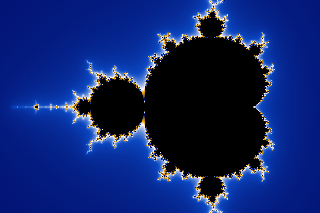

In [10]:
import "github.com/benc-uk/gofract/pkg/fractals"
import "github.com/benc-uk/gofract/pkg/colors"

%%
imgWidth := 320

// Default fractal
f := fractals.Fractal{
    FractType:    "mandelbrot",
    Center:       fractals.ComplexPair{-0.6, 0.0},
    MagFactor:    1.0,
    MaxIter:      90,
    W:            3.0,
    H:            2.0,
    ImgWidth:     imgWidth,
    JuliaSeed:    fractals.ComplexPair{0.355, 0.355},
    InnerColor:   "#000000",
    FullScreen:   false,
    ColorRepeats: 2,
}
gradient := colors.GradientTable{}
gradient.AddToTable("#000762", 0.0)
gradient.AddToTable("#0B48C3", 0.2)
gradient.AddToTable("#ffffff", 0.4)
gradient.AddToTable("#E3A000", 0.5)
gradient.AddToTable("#000762", 0.9)
imgHeight := int(float64(imgWidth) * float64(f.H/f.W))
img := image.NewRGBA(image.Rect(0, 0, f.ImgWidth, imgHeight))
lastRenderTime := f.Render(img, gradient)
fmt.Printf("lastRenderTime=%v\n", lastRenderTime)
gonbui.DisplayImage(img)


### SVG Drawing

From the amazing [SVGo library](https://github.com/ajstarks/svgo), I really wish I was that creative.
Below is Antony Stark's Shining example, [demoed here](https://speakerdeck.com/ajstarks/svgo-code-plus-picture-examples)

In [ ]:
import "bytes"
import svgo "github.com/ajstarks/svgo"
import "github.com/janpfeifer/gonb/gonbui"

func Shining(width, height int) string {
    buf := bytes.NewBuffer(nil)
    canvas := svgo.New(buf)
    xp := []int{50, 70, 70, 50, 30, 30}
    yp := []int{40, 50, 75, 85, 75, 50}
    xl := []int{0, 0, 50, 100, 100}
    yl := []int{100, 40, 10, 40, 100}
    bgcolor := "rgb(227,78,25)"
    bkcolor := "rgb(153,29,40)"
    stcolor := "rgb(65,52,44)"
    stwidth := 12
    stylefmt := "stroke:%s;stroke-width:%d;fill:%s"
    canvas.Start(width, height)
    canvas.Def()
    canvas.Gid("unit")
    canvas.Polyline(xl, yl, "fill:none")
    canvas.Polygon(xp, yp)
    canvas.Gend()
    canvas.Gid("runit")
    canvas.TranslateRotate(150, 180, 180)
    canvas.Use(0, 0, "#unit")
    canvas.Gend()
    canvas.Gend()
    canvas.DefEnd()
    canvas.Rect(0, 0, width, height, "fill:"+bgcolor)
    canvas.Gstyle(fmt.Sprintf(stylefmt, stcolor, stwidth, bkcolor))
    for y := 0; y < height; y += 130 {
        for x := -50; x < width; x += 100 {
            canvas.Use(x, y, "#unit")
            canvas.Use(x, y, "#runit")
        }
    }
    canvas.Gend()
    canvas.End()
    return buf.String()
}

%%
gonbui.DisplaySVG(Shining(500, 500))

<?xml version="1.0"?>
<!-- Generated by SVGo -->

### Plotting with [Margaid (SVG)](https://github.com/erkkah/margaid)

A real pearl!

Since its latest update is not yet "released" (tagged in Git), we needed to get the version on the specific commit. See "Executing Shell Commands" below.

In [12]:
!*go get -u github.com/erkkah/margaid@d60b2efd2f5acc5d8fbbe13eaf85f1532e11a2fb

go: downloading github.com/erkkah/margaid v0.1.1-0.20230128143048-d60b2efd2f5a
go: added github.com/erkkah/margaid v0.1.1-0.20230128143048-d60b2efd2f5a


In [13]:
import "bytes"
import "github.com/janpfeifer/gonb/gonbui"
import mg "github.com/erkkah/margaid"

func mgPlot(width, height int) string {
    randomSeries := mg.NewSeries()
    rand.Seed(time.Now().Unix())
    for i := float64(0); i < 10; i++ {
        randomSeries.Add(mg.MakeValue(i+1, 200*rand.Float64()))
    }

    testSeries := mg.NewSeries()
    multiplier := 2.1
    v := 0.33
    for i := float64(0); i < 10; i++ {
        v *= multiplier
        testSeries.Add(mg.MakeValue(i+1, v))
    }

    diagram := mg.New(width, height,
        mg.WithAutorange(mg.XAxis, testSeries),
        mg.WithAutorange(mg.YAxis, testSeries),
        mg.WithAutorange(mg.Y2Axis, testSeries),
        mg.WithProjection(mg.YAxis, mg.Log),
        mg.WithInset(70),
        mg.WithPadding(2),
        mg.WithColorScheme(90),
        mg.WithBackgroundColor("#f8f8f8"),
    )

    diagram.Line(testSeries, mg.UsingAxes(mg.XAxis, mg.YAxis), mg.UsingMarker("square"), mg.UsingStrokeWidth(1))
    diagram.Smooth(testSeries, mg.UsingAxes(mg.XAxis, mg.Y2Axis), mg.UsingStrokeWidth(3.14))
    diagram.Smooth(randomSeries, mg.UsingAxes(mg.XAxis, mg.YAxis), mg.UsingMarker("filled-circle"))
    diagram.Axis(testSeries, mg.XAxis, diagram.ValueTicker('f', 0, 10), false, "X")
    diagram.Axis(testSeries, mg.YAxis, diagram.ValueTicker('f', 1, 2), true, "Y")

    diagram.Frame()
    diagram.Title("A diagram of sorts ðŸ“Š ðŸ“ˆ")
    buf := bytes.NewBuffer(nil)
    diagram.Render(buf)
    return buf.String()
}

%%
gonbui.DisplaySVG(mgPlot(640, 480))

<path vector-effect="non-scaling-stroke" d="M1.000000e+01,6.800000e+00 C1.888889e+01,6.875434e+00 4.555556e+01,7.018758e+00 6.333333e+01,7.252602e+00 C8.111111e+01,7.486446e+00 9.888889e+01,7.711993e+00 1.166667e+02,8.203066e+00 C1.344444e+02,8.694139e+00 1.522222e+02,9.167786e+00 1.700000e+02,1.019904e+01 C1.877778e+02,1.123029e+01 2.055556e+02,1.222495e+01 2.233333e+02,1.439059e+01 C2.411111e+02,1.655622e+01 2.588889e+02,1.864500e+01 2.766667e+02,2.319283e+01 C2.944444e+02,2.774066e+01 3.122222e+02,3.212711e+01 3.300000e+02,4.167755e+01 C3.477778e+02,5.122798e+01 3.655556e+02,6.043953e+01 3.833333e+02,8.049545e+01 C4.011111e+02,1.005514e+02 4.188889e+02,1.198956e+02 4.366667e+02,1.620130e+02 C4.544444e+02,2.041305e+02 4.811111e+02,3.046688e+02 4.900000e+02,3.332000e+02 "/> <path vector-effect="non-scaling-stroke" d="M1.000000e+01,2.182456e+02 C1.888889e+01,2.283266e+02 4.555556e+01,2.754247e+02 6.333333e+01,2.787314e+02 C8.111111e+01,2.820380e+02 9.888889e+01,2.396605e+02 1.166667e+02,2.380855e+02 C1.344444e+02,2.365106e+02 1.522222e+02,2.717610e+02 1.700000e+02,2.692816e+02 C1.877778e+02,2.668022e+02 2.055556e+02,2.257349e+02 2.233333e+02,2.232091e+02 C2.411111e+02,2.206834e+02 2.588889e+02,2.451104e+02 2.766667e+02,2.541270e+02 C2.944444e+02,2.631436e+02 3.122222e+02,2.747703e+02 3.300000e+02,2.773088e+02 C3.477778e+02,2.798472e+02 3.655556e+02,2.801849e+02 3.833333e+02,2.693578e+02 C4.011111e+02,2.585308e+02 4.188889e+02,2.285050e+02 4.366667e+02,2.123467e+02 C4.544444e+02,1.961884e+02 4.811111e+02,1.790644e+02 4.900000e+02,1.724079e+02 "/> 1 2 3 4 5 6 7 8 9 10 X 1.0 2.0 4.0 8.0 16.0 32.0 64.0 128.0 256.0 512.0 Y A diagram of sorts ðŸ“Š ðŸ“ˆ

### Plotting with [Gonum Plot](https://github.com/gonum/plot) (SVG and PNG)



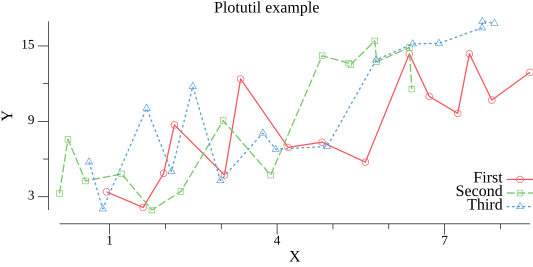

In [ ]:
import (
    "bytes"
    "math/rand"

    "github.com/janpfeifer/gonb/gonbui"
    "gonum.org/v1/plot"
    "gonum.org/v1/plot/plotter"
    "gonum.org/v1/plot/plotutil"
    "gonum.org/v1/plot/vg"
)

// randomPoints returns some random x, y points.
func randomPoints(n int) plotter.XYs {
    pts := make(plotter.XYs, n)
    for i := range pts {
        if i == 0 {
            pts[i].X = rand.Float64()
        } else {
            pts[i].X = pts[i-1].X + rand.Float64()
        }
        pts[i].Y = pts[i].X + 10*rand.Float64()
    }
    return pts
}

func GonumPlotExample(width, height int, format string) []byte {
    rand.Seed(int64(0))

    p := plot.New()

    p.Title.Text = "Plotutil example"
    p.X.Label.Text = "X"
    p.Y.Label.Text = "Y"

    err := plotutil.AddLinePoints(p,
        "First", randomPoints(15),
        "Second", randomPoints(15),
        "Third", randomPoints(15))
    if err != nil {
        panic(err)
    }

    buf := bytes.NewBuffer(nil)
    writerTo, err := p.WriterTo(vg.Points(float64(width)), vg.Points(float64(height)), format)
    if err != nil {
        panic(err)
    }
    writerTo.WriteTo(buf)
    return buf.Bytes()
}

%%
gonbui.DisplayPNG(GonumPlotExample(400, 200, "png"))

The version in SVG looks better though:

In [16]:
%%
gonbui.DisplaySVG(string(GonumPlotExample(400, 200, "svg")))

<?xml version="1.0"?>
<!-- Generated by SVGo and Plotinum VG -->
 
 
 
 Plotutil example 
 X 
 1 
 4 
 7 
 
 
 
 
 
 
 
 
 
 
 Y 
 
 3 
 9 
 15 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 First 
 
 
 Second 
 
 
 Third

## Executing Shell Commands

There are two variations to execute shell commands. They differ only on the directory
from where they are executed.

* `!` prefix executes what comes next should be executed as a shell command, on the same directory
  where the kernel is executed -- typically the same directory where the notebook files is saved.


In [17]:
!go version
!pwd ; ls -l

go version go1.20 linux/amd64
/home/janpf/Projects/gonb/examples
total 952
-rw-r--r-- 1 janpf janpf  15917 Feb  9 13:42 hello_world.ipynb
-rwxr-xr-x 1 janpf janpf 774123 Feb  9 13:42 tutorial.html
-rw-r--r-- 1 janpf janpf 156958 Feb  9 14:00 tutorial.ipynb


* `!*` prefix executes what comes next as a shell command, on the temporary directory used 
  to compile the *Go* program when executing the cells. This includes the `go.mod` file, that
  can be manipulated for special use cases, like importing a specific version of a module, 
  or to `redirect` a module to a local directory for development (see `Replace` section below)
  
Example:

In [18]:
!*pwd ; ls -l

/tmp/gonb_fb41a1f9
total 10740
-rw-r--r-- 1 janpf janpf     1268 Feb  9 14:01 go.mod
-rwxr-xr-x 1 janpf janpf 10974996 Feb  9 14:01 gonb_fb41a1f9
prw------- 1 janpf janpf        0 Feb  9 14:01 gonb_pipe_2390283674
-rw-r--r-- 1 janpf janpf     9877 Feb  9 14:01 go.sum
-rw-r--r-- 1 janpf janpf     3551 Feb  9 14:01 main.go


You can also use a `\` at the end of the line to extend the shell command to multiple lines.

Example:

In [19]:
!((ii=0)) ;\
while ((ii < 5)) ; do \
  printf "\rCounting: ${ii} ..." ;\
  sleep 1;\
  ((ii+=1));\
done;\
echo

Counting: 4 ...


## "Replace", Developing Go with a notebook

Using the `!*` command above we can easily "replace" a module to a local directory. This can be very handy
for developing a library in a powerful IDE on the side, and using the *GoNB* notebook to execute tests
and experiments. Changes in the library (in the IDE) when saved immediate take effect on the next cell execution.


The accompaining library *gonbui* was implemented mostly in this fashion using a notebook, that started with:

```
!*go mod edit -replace github.com/janpfeifer/gonb=/home/janpf/Projects/gonb
```

Check out the results with:

```
!*cat go.mod
```

In [20]:
!*go mod edit -replace github.com/janpfeifer/gonb=/home/janpf/Projects/gonb
!*cat go.mod

module gonb_fb41a1f9

go 1.20

require (
	github.com/ajstarks/svgo v0.0.0-20211024235047-1546f124cd8b
	github.com/benc-uk/gofract v0.0.0-20230120162050-a6f644f92fd6
	github.com/erkkah/margaid v0.1.1-0.20230128143048-d60b2efd2f5a
	github.com/janpfeifer/gonb v0.0.0-00010101000000-000000000000
	github.com/schollz/progressbar/v3 v3.13.0
	golang.org/x/exp v0.0.0-20230206171751-46f607a40771
	gonum.org/v1/plot v0.12.0
)

require (
	git.sr.ht/~sbinet/gg v0.3.1 // indirect
	github.com/go-fonts/liberation v0.2.0 // indirect
	github.com/go-latex/latex v0.0.0-20210823091927-c0d11ff05a81 // indirect
	github.com/go-pdf/fpdf v0.6.0 // indirect
	github.com/golang/freetype v0.0.0-20170609003504-e2365dfdc4a0 // indirect
	github.com/lucasb-eyer/go-colorful v1.0.3 // indirect
	github.com/mattn/go-runewidth v0.0.14 // indirect
	github.com/mitchellh/colorstring v0.0.0-20190213212951-d06e56a500db // indirect
	github.com/pkg/errors v0.9.1 // indirect
	github.com/rivo/uniseg v0.4.3 // indirect
	golang.org/x/im

## More ... and Help

The library is new, and there is still development going on. Much more is planned (on the displaying side, auto-complete, contextual information, better error handling). For those
who enjoy coding, help in improving *GoNB* is very welcome!

Finally, there is also the `%help` command, which lists all the currently supported features:

In [21]:
%help

GoNB is a Go kernel that compiles and executed on-the-fly Go code. 

When executing a cell, *GoNB* will save the cell contents (except non-Go commands see
below) into a "main.go" file, compile and execute it.

It also saves any global declarations (imports, functions, types, variables, constants)
and reuse them at the next cell execution -- so you can define a function in one
cell, and reuse in the next one. Just the "func main()" is not reused.

A "hello world" example would look like:

	func main() {
		fmt.Printf("Hello world!\n");
	}

But to avoid having to type "func main()" all the time, you can use "%%" and everything
after is wrapped inside a "func main() { ... }". So our revised "hello world" looks like:

	%%
	fmt.Printf("Hello world!\n")


- "init()" functions: since there is always only one definition per function name, 
  it's not possible for each cell to have it's own init() function. Instead GoNB
  converts any function named "init_<my_stuff>()" to "init()" before compili